In [1]:
### Atom class + readframe + lines_in_file functions - used to process dump files

import numpy as np
import operator # do we need this?

class Atom:
    """ A Class for storing atom information """

    def __init__(self):
        """ Initialise the class """
        self.id = 0                                              # id of the atom
        self.type = 0                                            # type of the atom
        self.L = np.array([0.0,0.0,0.0],dtype=np.float64)        # size of simulation box
        self.half_L = self.L / 2                                 # half the size of simulation box
        self.x = np.array([0.0,0.0,0.0],dtype=np.float64)        # position of the atom
        self.image = np.array([0,0,0],dtype=np.int32)            # image flags for atoms
        self.x_unwrap = np.array([0.0,0.0,0.0],dtype=np.float64) # position of the atom - unwrapped coords
        self.unwrap_flag = False

    
    def sep(self, atom2):
        """ Takes in self and atom2 and finds separation between them taking into account periodic BCs """

        dx = self.x[0] - atom2.x[0]
        dy = self.x[1] - atom2.x[1]
        dz = self.x[2] - atom2.x[2]

        if dx > self.half_L[0]:
            dx = self.L[0] - dx
        if dy > self.half_L[1]:
            dy = self.L[1] - dy
        if dz > self.half_L[2]:
            dz = self.L[2] - dz

        return np.sqrt(dx**2 + dy**2 + dz**2)
    
    def sep_2(self, atom2):
        """ Takes in self and atom2 and finds their separation SQUARED WITHOUT taking into account periodic BCs """

        dx = self.x[0] - atom2.x[0]
        dy = self.x[1] - atom2.x[1]
        dz = self.x[2] - atom2.x[2]

        """
        if dx > self.half_L[0]:
            dx = self.L[0] - dx
        if dy > self.half_L[1]:
            dy = self.L[1] - dy
        if dz > self.half_L[2]:
            dz = self.L[2] - dz
        """

        return dx**2 + dy**2 + dz**2

    def minus(self,B):
        """ Subtract B.x vector from self.x vector """
        
        AminusB = np.array([0.0,0.0,0.0],dtype=np.float64)
        for i in range(3):
            AminusB[i] = self.x[i] - B.x[i]
            
        return AminusB

    def xdot(self,B):
        """ Find dot product of position x of this Atom and Atom B """
        
        AdotB = np.array([0.0,0.0,0.0],dtype=np.float64) # TO DO : find AdotB ??
        
        return AdotB

    # confused as to what this function does :/ - isn't unwrap_flag always False?
    def unwrap(self):
        """ Unwraps the coordinates for periodic box to generate x_unwrap array """
        
        if not self.unwrap_flag:   # first check it has not already been done
            for j in range(3):
                self.x_unwrap[j] = self.x[j] + self.image[j]*self.L[j] # unwrap
            unwrap_flag = True

In [2]:
### functions

def readframe(infile, N):
    """ Read a single frame of N atoms from a dump file 
        Expects coordinates to be in range -L/2 to L/2
        DOES NOT Unwrap corrdinates for periodic box """

    atoms = [Atom() for i in range(N)]
    L = np.array([0.0,0.0,0.0],dtype=np.float64)

    # read in the 9 header lines of the dump file
    # get box size
    for i in range(9):
        line = infile.readline()
        if i==1:  ## second line of frame is timestep
            timestep = np.int32(line)
        if i==5 or i==6 or i==7:   # 6th-8th lines are box size in x,y,z dimensions
            # get the box size
            line = line.split()
            L[i-5]=np.float64(line[1]) - np.float64(line[0]);

    # now read the atoms, putting them at the correct index (index=id-1)
    for i in range(N):
        line = infile.readline()
        line = line.split()
        index = int(line[0])-1  # LAMMPS atom ids start from 1, python index starts from 0
        atoms[index].id = int(line[0])
        atoms[index].type = int(line[1])
        atoms[index].L = L
        for j in range(3):
            atoms[index].x[j] = np.float64(line[j+2])
        for j in range(3):
            atoms[index].image[j] = np.int32(line[j+5])

    return atoms, timestep


def lines_in_file(filename):
    """ Get the number of lines in the file """

    with open(filename) as f:
        for i, l in enumerate(f):
            pass

    return i + 1

In [3]:
### calculation functions

import statistics as s

def dbscan(atoms, threshold, target_type):
    """ Takes in a list of Atom objects, distance threshold + target type. 
        Sets the cluster id for atoms we are not interested in to -2.
        Returns a list of cluster ids where the ith element is the cluster id for ith atom in input list """

    if not atoms: # edge case of empty atom list - return an empty cluster id list
        return []

    cluster_id = 0
    cluster_ids = [-1] * len(atoms)  # Initialize cluster IDs for each atom; -1 means unclassified

    threshold_2 = threshold**2

    def find_neighbors(atom_index):
        """ Takes in index of an atom and find the neighbours of that atom. 
            Atoms are neighbours if within threshold distance of 2.4.
            Returns a list of neighbours of type=4 for atom index inputted """

        return [i for i, other_atom in enumerate(atoms)
                if i != atom_index and atoms[atom_index].type == target_type and other_atom.type == target_type and 
                atoms[atom_index].sep_2(other_atom) < threshold_2]
    
    # loops through atoms list
    for i in range(len(atoms)):

        # checks to see if cluster id of ith atom is -1 - if not atom already processed
        if cluster_ids[i] != -1 or atoms[i].type != target_type:

            # checks to see if atom type is target type - if not sets cluster id of that atom to -2 (not of interest)
            if atoms[i].type != target_type:
                cluster_ids[i] = -2

            continue

        neighbors = find_neighbors(i) # finds neighbours of atom i

        cluster_id += 1
        cluster_ids[i] = cluster_id

        k = 0

        # for every neighbour of atom i, finds the neighbours of that neighbour and adds it to original neighbour list
        while k < len(neighbors):
            neighbor_idx = neighbors[k]
            if cluster_ids[neighbor_idx] == -1:
                cluster_ids[neighbor_idx] = cluster_id

                new_neighbors = find_neighbors(neighbor_idx)
                for new_neighbor in new_neighbors:
                    if cluster_ids[new_neighbor] == -1:
                        neighbors.append(new_neighbor)
            k += 1
            
    no_of_clusters = cluster_id # cluster_id acts like a 'cluster count'

    return no_of_clusters, cluster_ids

In [4]:
def size_of_clusters(cluster_ids):
    """ Takes in a list of cluster ids. Returns a list of the number of proteins in a cluster, ignoring cluster ids of -2.
        Eg: [-2, -2, ..., 1, 4, 2, 4, 1, 3, 4, ...] --> 2 in cluster 1, 1 in cluster 2, 1 in cluster 3, 3 in cluster 4 ... """
    
    size_of_clusters = [0] * max(cluster_ids) # 0 means 0 atoms in cluster i
    
    # loop through list of cluster ids
    for i in cluster_ids:
        
        # if the cluster id is not -2 (-2 are atoms of non-interest)
        if i != -2:
            # increase value of i-1 by 1
            size_of_clusters[i-1] += 1
                    
    return size_of_clusters



def mean_size_of_clusters(size_of_clusters):
    """ Takes in list of cluster sizes (in number of proteins) and returns the mean number of proteins in a cluster """
    
    return s.fmean(size_of_clusters) # fmean runs faster than mean apparently



def size_of_largest_cluster(size_of_clusters):
    """ Takes in list of cluster sizes and returns the number of proteins in largest cluster """
    
    return max(size_of_clusters)


def no_of_clusters_size_1(size_of_clusters):
    """ Takes in a list of cluster sizes and returns the number of clusters with only 1 protein - i.e. size 1 """

    return size_of_clusters.count(1)


def no_proteins_bound_to_poly(atoms, target_types={1, 2, 3}, threshold_2=3.24):
    """ Takes in a list of Atom objects. 
        Returns the no of proteins bound to the polymer of type=1, 2 or 3 + list of no of polymer beads an atom is bound to. """

    def find_polymers_bound_to(j):
        """ Takes in index of a protein (type 4) and finds if it is bound to polymer (type=1, 2 or 3). 
            Bound to polymer if within threshold distance of 1.8. Or if sep_2 < threshold_2 (3.24).
            Returns a list of indices of polymer beads of type=1, 2 or 3 for atom index inputted. 
            Length of list is no of polymer beads that protein is bound to. """

        return [i for i, other_atom in enumerate(atoms)
                #if i != j and other_atom.type in {2} and atoms[j].sep2(other_atom) < threshold_2]
                if i != j and other_atom.type in target_types and atoms[j].sep_2(other_atom) < threshold_2]


    no_proteins_bound = 0 # intialises counter of number of proteins bound to a polymer bead to 0
    no_polymers_bound_to = [0] * len(atoms) # initialises list of number of polymer beads that each protein is bound to, to 0

    # loops through all atoms - could make it loop through just the last 300 as those are the proteins!
    for j, atom in enumerate(atoms):

        # if atom is a protein (type 4)
        if atom.type == 4:

            # find number of polymer beads (of any type - 1, 2 or 3) that protein is bound to
            poly_beads_list = find_polymers_bound_to(j)
            no_polymers_bound_to[j] = len(poly_beads_list) # length of list is the no of polymer beads that protein is bound to

            # if list is not empty
            if poly_beads_list:
                no_proteins_bound += 1

    return no_proteins_bound, no_polymers_bound_to

In [5]:
def fraction_clusters_bound_to_poly(atoms, cluster_ids, cluster_no):
    """ Takes in a list of Atom objects, their cluster ids and no_of_clusters (at each frame). 
        Returns the fraction of clusters bound to the polymer of type=1, 2 or 3 """

    def protein_bound_to_poly(j):
        """ Takes in index of a protein in cluster (type 4) and finds if it is bound to polymer (type=1, 2 or 3). 
            Bound to polymer if within threshold distance of 1.8. Or if sep_2 < threshold_2 (3.24). 
            Stops and returns True if it is bound. False if not bound. """
        for i, other_atom in enumerate(atoms):
            if i != j and other_atom.type in target_types and atoms[j].sep_2(other_atom) < threshold_2:
                return True # stop when you find a protein in cluster that is within threshold distance of any polymer bead
        return False

    bound_clusters = []  # list of cluster ids of bound clusters
    print("bound clusters list: ", bound_clusters)
    target_types={1, 2, 3}
    threshold_2=3.24

    # loop through all cluster ids
    for j, cluster_id in enumerate(cluster_ids):
        
        # if cluster_id is not -2 (ie: it is the cluster id of a protein) and it is not already in bound_clusters
        if cluster_id != -2 and cluster_id not in bound_clusters:

            # check if the protein belonging to that cluster id is bound to a polymer bead. If it is add cluster id to bound_clusters list.
            if protein_bound_to_poly(j):
                bound_clusters.append(cluster_id)

    fraction_bound = len(bound_clusters) / cluster_no # no of bound clusters / total no of clusters
    
    print("---------------------------------------------")
    print("total no of clusters: ",cluster_no)
    print("bound clusters list: ", bound_clusters)
    print("no of bound clusters: ",len(bound_clusters))
    print("frac of bound clusters: ",fraction_bound)
    print("---------------------------------------------")

    return fraction_bound

In [ ]:
### main programs --> need to change this cause very sucky!

######################## - User inputs (sys argv command line) but worse cause need to remember the order of inputs :/

"""
dumpfilename = sys.argv[1] # name of dump file to read - dump.sticky_DNA+proteins

Natoms = int(sys.argv[2]) # no of atoms - 220
Npoly = int(sys.argv[3]) # no of polymer atoms - 200

outfile_Rg = sys.argv[4] # name of output file - r_g_sticky_DNA

thresh = float(sys.argv[5]) # cluster threshold - 2.4
"""

######################## - Hardcoded (use for testing)

#name_dumpfile = 'dump.sticky_DNA+proteins' # name of dump file to read - dump.sticky_DNA+proteins

#n_atoms = 220 # no of atoms - 220
#n_poly_atoms = 200 # no of polymer atoms - 200

#name_outfile = 'r_g_sticky_DNA' # name of output file - r_g_sticky_DNA

######################## - User inputs (command line) - best way imo

name_dumpfile = input("Name of dumpfile: ")

n_atoms = int(input("Integer no of atoms (in df): "))
n_poly_atoms = int(input("Integer no of polymer atoms (in df): "))

name_outfile = input("Name of output file: ")

########################

# TO DO: could make this more automatic by giving a default of everything... user can say y/n to default and change if required

threshold = 2.4 # cluster threshold - 2.4
target_type = 4  # target atom type - should change this to type 4 for model simulations... / could add as user input

path_to_dumpfiles = '../../lammps_sims/dumpfiles/' # need to change this when running on local computer
path_to_outfiles = '../outfiles/'

n_lines = lines_in_file(path_to_dumpfiles + name_dumpfile) # no of lines in file
n_frames = int(n_lines / (n_atoms + 9)) # +9 as 9 header lines in each frame

# open the input file
file_in = open(path_to_dumpfiles + name_dumpfile, 'r')

# open the output file and print a header
file_out = open(path_to_outfiles + name_outfile, 'w')
file_out.write("# Timesteps, No of clusters, Fraction of clusters bound\n")

# go through the file frame by frame
for frame in range(n_frames):
    # read the frame, unwrapping periodic coordinates
    atoms, timesteps = readframe(file_in, n_atoms)
    
    # unwarp period boundary coordinates -- needed for clusters? - think so as a cluster can form between boundaries
    for i in range(len(atoms)):
        atoms[i].unwrap()

    # perform calculations
    no_of_clusters, cluster_ids = dbscan(atoms, threshold, target_type)
    print("No of clusters: ", no_of_clusters)
    #cluster_size = size_of_clusters(cluster_ids)
    #mean_cluster_size = mean_size_of_clusters(cluster_size)
    #largest_cluster_size = size_of_largest_cluster(cluster_size)
    
    #no_proteins_bound, no_polymers_bound_to = no_proteins_bound_to_poly(atoms)
    
    frac_clusters_bound = fraction_clusters_bound_to_poly(atoms, cluster_ids, int(no_of_clusters))
    
    # output some results
    #file_out.write("%i %i %i %i\n"%(timesteps, no_of_clusters, mean_cluster_size, largest_cluster_size))
    file_out.write("%i %i %.2f\n"%(timesteps, no_of_clusters, frac_clusters_bound))

# close the files
file_in.close()
file_out.close()

In [8]:
import os
from tqdm import tqdm  # Ensure you have tqdm installed

# Assuming necessary functions are defined elsewhere:
# lines_in_file, readframe, dbscan, size_of_clusters, mean_size_of_clusters,
# size_of_largest_cluster, no_of_clusters_size_1, no_proteins_bound_to_poly

threshold = 2.4  # cluster threshold
target_type = 4  # target atom type

n_atoms = 5300 #int(input("Integer no of atoms (in df): "))
n_poly_atoms = 5000

path_to_dumpfiles = '../../lammps_sims/dumpfiles/'
path_to_outfiles = '../outfiles/'

# Assuming 'name_dumpfile' and 'n_atoms' are defined elsewhere
name_dumpfile = 'dump_model_4_var_1_run_1.dat'  # Replace with actual dumpfile name
name_outfile = 'outfile_test.dat'            # Replace with desired outfile name
name_cluster_size_file = 'cluster_sizes_test.dat'  # New file for cluster sizes

n_lines = lines_in_file(os.path.join(path_to_dumpfiles, name_dumpfile))
n_frames = int(n_lines / (n_atoms + 9))  # +9 for header lines

# Open the input file
file_in = open(os.path.join(path_to_dumpfiles, name_dumpfile), 'r')

# Open the output file and print a header
file_out = open(os.path.join(path_to_outfiles, name_outfile), 'w')
file_out.write("# Timesteps, No of clusters, Mean cluster size, Size largest cluster, No clusters size 1, No proteins bound to poly\n")

# Open the new file for cluster sizes
file_cluster_size_out = open(os.path.join(path_to_outfiles, name_cluster_size_file), 'w')

# Process the file frame by frame
for frame in tqdm(range(n_frames)):
    # Read the frame, unwrapping periodic coordinates
    atoms, timesteps = readframe(file_in, n_atoms)
    
    # Unwrap periodic boundary coordinates
    for i in range(len(atoms)):
        atoms[i].unwrap()

    # Perform calculations on clusters
    no_of_clusters, cluster_ids = dbscan(atoms, threshold, target_type)
    cluster_size = size_of_clusters(cluster_ids)
    print("cluster sizes: ",cluster_size)
    mean_cluster_size = mean_size_of_clusters(cluster_size)
    #largest_cluster_size = size_of_largest_cluster(cluster_size)
    #size_1_count = no_of_clusters_size_1(cluster_size)
    #no_proteins_bound, no_polymers_bound_to = no_proteins_bound_to_poly(atoms)
    
    # Output results to the main file
    file_out.write("%i %i %.5f\n" % (timesteps, no_of_clusters, mean_cluster_size))

    # Output the cluster_size list to the cluster size file
    file_cluster_size_out.write(f"{timesteps}: {','.join(map(str, cluster_size))}\n")

# Close all files
file_in.close()
file_out.close()
file_cluster_size_out.close()

  0%|          | 1/401 [00:00<02:58,  2.24it/s]

cluster sizes:  [1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  0%|          | 2/401 [00:00<02:59,  2.23it/s]

cluster sizes:  [1, 1, 1, 2, 1, 1, 4, 1, 1, 3, 6, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 3, 2, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  1%|          | 3/401 [00:01<02:59,  2.22it/s]

cluster sizes:  [1, 5, 1, 5, 1, 1, 1, 1, 3, 2, 13, 1, 1, 1, 2, 6, 3, 3, 4, 2, 1, 1, 6, 3, 6, 1, 1, 1, 12, 2, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 5, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 7, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  1%|          | 4/401 [00:01<02:59,  2.21it/s]

cluster sizes:  [11, 4, 5, 1, 1, 2, 5, 1, 14, 1, 1, 1, 3, 7, 11, 12, 7, 1, 1, 6, 1, 7, 1, 5, 1, 13, 2, 1, 1, 1, 1, 3, 2, 1, 1, 2, 3, 1, 5, 1, 2, 7, 1, 4, 1, 4, 2, 2, 1, 1, 3, 1, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  1%|          | 5/401 [00:02<02:58,  2.22it/s]

cluster sizes:  [14, 3, 9, 1, 2, 1, 19, 2, 17, 1, 2, 3, 9, 11, 13, 7, 1, 1, 5, 1, 7, 1, 5, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 5, 2, 7, 2, 1, 1, 6, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 1, 3, 1, 2, 1, 5, 1, 5, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  1%|▏         | 6/401 [00:02<02:59,  2.20it/s]

cluster sizes:  [14, 1, 2, 9, 1, 3, 1, 21, 2, 17, 1, 2, 5, 10, 12, 15, 7, 3, 1, 9, 7, 1, 1, 6, 1, 1, 1, 1, 3, 3, 1, 2, 1, 5, 2, 7, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 1, 1, 3, 1, 1, 4, 1, 5, 1, 3, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  2%|▏         | 7/401 [00:03<02:58,  2.21it/s]

cluster sizes:  [16, 5, 1, 19, 1, 1, 1, 22, 2, 17, 1, 2, 6, 14, 16, 6, 1, 10, 7, 2, 5, 7, 1, 2, 1, 5, 3, 2, 1, 2, 1, 6, 2, 8, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 3, 5, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  2%|▏         | 8/401 [00:03<02:57,  2.22it/s]

cluster sizes:  [17, 5, 7, 19, 6, 1, 4, 23, 2, 17, 1, 6, 13, 17, 6, 11, 7, 1, 5, 7, 1, 1, 1, 5, 1, 3, 2, 1, 2, 1, 2, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 1, 3, 5, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  2%|▏         | 9/401 [00:04<02:56,  2.22it/s]

cluster sizes:  [19, 11, 7, 24, 3, 3, 24, 18, 1, 6, 15, 17, 8, 11, 10, 1, 1, 8, 1, 1, 1, 5, 3, 1, 1, 1, 1, 4, 8, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 5, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  2%|▏         | 10/401 [00:04<02:56,  2.21it/s]

cluster sizes:  [19, 5, 7, 24, 7, 3, 4, 26, 19, 6, 15, 17, 8, 13, 8, 1, 8, 1, 2, 1, 6, 1, 3, 4, 2, 1, 2, 4, 9, 1, 1, 2, 1, 4, 1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


  3%|▎         | 11/401 [00:04<02:55,  2.22it/s]

cluster sizes:  [19, 4, 7, 24, 7, 3, 1, 27, 19, 3, 6, 16, 18, 8, 14, 8, 1, 1, 1, 3, 2, 5, 1, 1, 1, 1, 1, 4, 10, 1, 1, 1, 1, 1, 1, 5, 1, 4, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  3%|▎         | 12/401 [00:05<02:55,  2.21it/s]

cluster sizes:  [19, 4, 7, 26, 7, 3, 1, 27, 20, 1, 6, 18, 18, 1, 14, 8, 1, 3, 1, 2, 2, 5, 1, 1, 1, 1, 5, 10, 7, 1, 1, 1, 1, 1, 1, 7, 1, 5, 2, 2, 4, 1, 1, 2, 1, 1, 1, 7, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  3%|▎         | 13/401 [00:05<02:57,  2.19it/s]

cluster sizes:  [21, 4, 7, 26, 7, 3, 1, 26, 21, 1, 7, 1, 19, 1, 14, 8, 1, 1, 3, 9, 1, 2, 1, 1, 12, 1, 14, 1, 4, 7, 1, 1, 1, 1, 1, 1, 4, 1, 5, 1, 2, 4, 2, 1, 1, 1, 7, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  3%|▎         | 14/401 [00:06<02:59,  2.16it/s]

cluster sizes:  [22, 4, 7, 26, 8, 4, 1, 26, 21, 10, 7, 14, 19, 14, 6, 1, 1, 4, 1, 1, 1, 12, 1, 1, 5, 4, 7, 1, 1, 2, 1, 1, 5, 6, 2, 1, 1, 4, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  4%|▎         | 15/401 [00:06<02:58,  2.16it/s]

cluster sizes:  [22, 4, 7, 26, 7, 4, 8, 27, 1, 21, 11, 7, 13, 20, 14, 6, 1, 2, 6, 1, 1, 1, 12, 1, 1, 4, 1, 5, 1, 1, 1, 1, 6, 8, 2, 4, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  4%|▍         | 16/401 [00:07<02:56,  2.18it/s]

cluster sizes:  [21, 4, 7, 26, 7, 4, 8, 1, 22, 21, 26, 12, 7, 13, 15, 6, 1, 2, 6, 1, 3, 1, 12, 1, 1, 1, 5, 1, 1, 1, 5, 11, 2, 1, 1, 1, 7, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  4%|▍         | 17/401 [00:07<02:55,  2.19it/s]

cluster sizes:  [21, 4, 13, 42, 6, 8, 7, 22, 21, 26, 12, 7, 15, 1, 6, 1, 1, 1, 2, 12, 1, 1, 5, 1, 4, 1, 5, 11, 2, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]


  4%|▍         | 18/401 [00:08<02:58,  2.15it/s]

cluster sizes:  [22, 4, 13, 43, 6, 7, 7, 22, 22, 27, 12, 7, 16, 1, 5, 1, 1, 1, 1, 12, 8, 2, 1, 5, 1, 4, 1, 1, 1, 5, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]


  5%|▍         | 19/401 [00:08<02:56,  2.16it/s]

cluster sizes:  [23, 4, 14, 43, 6, 7, 7, 22, 22, 27, 11, 7, 14, 1, 5, 1, 2, 1, 3, 12, 8, 1, 4, 1, 4, 1, 1, 1, 1, 5, 10, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]


  5%|▍         | 20/401 [00:09<02:57,  2.15it/s]

cluster sizes:  [23, 4, 14, 44, 6, 8, 7, 23, 23, 27, 10, 8, 1, 1, 5, 1, 2, 1, 3, 12, 12, 8, 1, 4, 1, 4, 1, 1, 1, 1, 5, 1, 9, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]


  5%|▌         | 21/401 [00:09<02:56,  2.16it/s]

cluster sizes:  [23, 4, 14, 44, 6, 8, 7, 23, 23, 27, 8, 8, 3, 1, 5, 1, 2, 1, 2, 12, 13, 8, 1, 5, 1, 4, 1, 1, 1, 5, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]


  5%|▌         | 22/401 [00:10<02:55,  2.16it/s]

cluster sizes:  [23, 4, 15, 44, 6, 8, 7, 23, 23, 28, 8, 8, 1, 1, 5, 1, 2, 9, 2, 12, 13, 1, 5, 1, 1, 1, 1, 1, 5, 1, 10, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]


  6%|▌         | 23/401 [00:10<02:56,  2.15it/s]

cluster sizes:  [23, 4, 15, 44, 6, 8, 7, 24, 25, 28, 7, 8, 1, 1, 6, 1, 8, 2, 12, 13, 1, 4, 1, 1, 1, 1, 1, 1, 6, 1, 10, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1]


  6%|▌         | 24/401 [00:10<02:54,  2.16it/s]

cluster sizes:  [23, 4, 23, 44, 6, 9, 31, 25, 44, 7, 1, 1, 1, 1, 13, 13, 1, 1, 3, 1, 1, 1, 1, 6, 1, 10, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1]


  6%|▌         | 25/401 [00:11<02:53,  2.17it/s]

cluster sizes:  [23, 4, 23, 45, 6, 8, 32, 25, 45, 7, 1, 1, 2, 1, 13, 13, 1, 1, 3, 1, 1, 3, 1, 5, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1]


  6%|▋         | 26/401 [00:11<02:52,  2.18it/s]

cluster sizes:  [23, 4, 23, 45, 5, 8, 33, 25, 45, 7, 1, 2, 1, 14, 13, 1, 1, 1, 3, 1, 1, 3, 1, 4, 1, 10, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  7%|▋         | 27/401 [00:12<02:51,  2.18it/s]

cluster sizes:  [23, 4, 23, 45, 5, 8, 33, 26, 43, 7, 1, 3, 1, 1, 13, 13, 1, 1, 1, 4, 2, 4, 1, 4, 1, 10, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  7%|▋         | 28/401 [00:12<02:50,  2.19it/s]

cluster sizes:  [23, 4, 23, 45, 6, 8, 33, 26, 43, 8, 1, 1, 1, 1, 13, 13, 1, 1, 1, 4, 1, 1, 4, 1, 4, 10, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  7%|▋         | 29/401 [00:13<02:51,  2.17it/s]

cluster sizes:  [22, 4, 23, 45, 6, 8, 34, 27, 43, 7, 1, 1, 1, 1, 14, 13, 1, 2, 1, 4, 1, 1, 4, 4, 9, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  7%|▋         | 30/401 [00:13<02:49,  2.19it/s]

cluster sizes:  [21, 4, 23, 46, 6, 9, 34, 27, 44, 7, 2, 1, 1, 1, 14, 13, 1, 1, 3, 1, 3, 1, 3, 9, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  8%|▊         | 31/401 [00:14<02:47,  2.20it/s]

cluster sizes:  [21, 4, 24, 46, 6, 9, 36, 27, 45, 1, 1, 1, 6, 1, 14, 13, 1, 2, 1, 3, 1, 1, 9, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  8%|▊         | 32/401 [00:14<02:48,  2.19it/s]

cluster sizes:  [21, 4, 24, 47, 6, 9, 37, 41, 45, 1, 1, 1, 6, 1, 14, 1, 2, 1, 3, 1, 9, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  8%|▊         | 33/401 [00:15<02:47,  2.20it/s]

cluster sizes:  [21, 4, 24, 47, 6, 9, 38, 42, 45, 1, 1, 7, 1, 14, 1, 2, 1, 3, 1, 9, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  8%|▊         | 34/401 [00:15<02:47,  2.19it/s]

cluster sizes:  [21, 4, 24, 48, 6, 9, 38, 42, 46, 1, 1, 1, 1, 14, 2, 2, 1, 1, 6, 9, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  9%|▊         | 35/401 [00:16<02:46,  2.19it/s]

cluster sizes:  [21, 4, 24, 49, 6, 9, 38, 42, 46, 1, 1, 1, 1, 14, 2, 2, 1, 2, 6, 9, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  9%|▉         | 36/401 [00:16<02:47,  2.18it/s]

cluster sizes:  [21, 4, 24, 49, 6, 9, 38, 42, 46, 1, 1, 1, 1, 14, 2, 2, 1, 1, 6, 9, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  9%|▉         | 37/401 [00:16<02:46,  2.18it/s]

cluster sizes:  [21, 4, 25, 49, 6, 8, 38, 42, 47, 1, 1, 1, 1, 14, 3, 2, 3, 7, 9, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


  9%|▉         | 38/401 [00:17<02:45,  2.19it/s]

cluster sizes:  [21, 4, 25, 49, 6, 8, 39, 41, 48, 1, 1, 1, 1, 15, 3, 2, 2, 6, 8, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


 10%|▉         | 39/401 [00:17<02:45,  2.19it/s]

cluster sizes:  [22, 4, 25, 49, 6, 8, 39, 41, 48, 1, 1, 2, 2, 15, 3, 2, 8, 8, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 10%|▉         | 40/401 [00:18<02:44,  2.19it/s]

cluster sizes:  [22, 3, 25, 49, 6, 8, 54, 41, 47, 1, 1, 1, 2, 3, 2, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 10%|█         | 41/401 [00:18<02:46,  2.16it/s]

cluster sizes:  [22, 5, 25, 49, 6, 8, 54, 41, 48, 1, 1, 1, 1, 3, 2, 1, 8, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 10%|█         | 42/401 [00:19<02:45,  2.17it/s]

cluster sizes:  [22, 4, 25, 49, 6, 8, 55, 41, 48, 1, 9, 1, 1, 3, 2, 1, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 11%|█         | 43/401 [00:19<02:44,  2.18it/s]

cluster sizes:  [22, 4, 25, 49, 7, 9, 54, 43, 47, 1, 9, 1, 1, 2, 2, 1, 1, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 11%|█         | 44/401 [00:20<02:44,  2.16it/s]

cluster sizes:  [22, 5, 26, 49, 7, 10, 54, 45, 47, 1, 9, 1, 2, 2, 2, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 11%|█         | 45/401 [00:20<02:44,  2.17it/s]

cluster sizes:  [22, 5, 26, 49, 1, 10, 54, 45, 47, 1, 9, 1, 3, 2, 2, 6, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1]


 11%|█▏        | 46/401 [00:21<02:43,  2.18it/s]

cluster sizes:  [22, 5, 26, 49, 1, 10, 55, 44, 45, 8, 2, 3, 1, 2, 1, 6, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


 12%|█▏        | 47/401 [00:21<02:42,  2.18it/s]

cluster sizes:  [22, 5, 27, 50, 1, 9, 55, 44, 45, 8, 3, 2, 1, 6, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 48/401 [00:21<02:41,  2.18it/s]

cluster sizes:  [22, 5, 27, 51, 2, 9, 55, 44, 45, 9, 2, 2, 1, 1, 7, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 49/401 [00:22<02:40,  2.19it/s]

cluster sizes:  [22, 5, 27, 51, 1, 9, 55, 43, 45, 9, 2, 2, 1, 5, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 12%|█▏        | 50/401 [00:22<02:41,  2.17it/s]

cluster sizes:  [22, 1, 26, 51, 1, 9, 55, 44, 45, 9, 1, 1, 2, 1, 1, 8, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 51/401 [00:23<02:41,  2.16it/s]

cluster sizes:  [22, 1, 27, 51, 1, 10, 56, 43, 45, 9, 2, 2, 1, 8, 1, 1, 1, 2, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 52/401 [00:23<02:41,  2.16it/s]

cluster sizes:  [22, 1, 27, 51, 1, 9, 57, 43, 44, 9, 2, 2, 1, 8, 1, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 53/401 [00:24<02:40,  2.17it/s]

cluster sizes:  [22, 2, 26, 52, 1, 9, 57, 42, 44, 9, 2, 2, 1, 8, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 13%|█▎        | 54/401 [00:24<02:39,  2.18it/s]

cluster sizes:  [22, 1, 26, 52, 1, 9, 58, 41, 44, 9, 2, 2, 1, 8, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▎        | 55/401 [00:25<02:39,  2.17it/s]

cluster sizes:  [22, 1, 26, 53, 1, 8, 58, 42, 44, 9, 2, 2, 1, 9, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 56/401 [00:25<02:38,  2.18it/s]

cluster sizes:  [22, 1, 26, 53, 5, 8, 58, 42, 44, 10, 2, 2, 1, 9, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 57/401 [00:26<02:37,  2.18it/s]

cluster sizes:  [22, 1, 26, 53, 1, 9, 58, 43, 44, 10, 2, 2, 9, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1]


 14%|█▍        | 58/401 [00:26<02:36,  2.19it/s]

cluster sizes:  [22, 1, 26, 53, 1, 9, 58, 44, 44, 10, 2, 2, 9, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 1]


 15%|█▍        | 59/401 [00:27<02:37,  2.18it/s]

cluster sizes:  [22, 1, 26, 54, 1, 9, 59, 44, 44, 10, 2, 1, 9, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1]


 15%|█▍        | 60/401 [00:27<02:36,  2.18it/s]

cluster sizes:  [22, 1, 26, 54, 1, 9, 57, 44, 44, 9, 2, 1, 1, 9, 1, 1, 1, 5, 1, 1, 4, 1, 1, 1, 1, 1, 1]


 15%|█▌        | 61/401 [00:27<02:35,  2.18it/s]

cluster sizes:  [22, 1, 26, 54, 1, 9, 57, 45, 44, 9, 5, 1, 1, 9, 1, 5, 1, 1, 4, 1, 1, 1, 1]


 15%|█▌        | 62/401 [00:28<02:34,  2.19it/s]

cluster sizes:  [22, 1, 26, 54, 11, 9, 57, 45, 44, 4, 1, 9, 1, 5, 1, 1, 4, 1, 1, 1, 1, 1]


 16%|█▌        | 63/401 [00:28<02:34,  2.19it/s]

cluster sizes:  [22, 1, 26, 54, 11, 9, 58, 46, 44, 4, 1, 10, 5, 4, 1, 1, 1, 1, 1]


 16%|█▌        | 64/401 [00:29<02:33,  2.19it/s]

cluster sizes:  [22, 12, 26, 54, 9, 58, 45, 44, 4, 1, 10, 1, 5, 3, 1, 1, 1, 1, 1, 1]


 16%|█▌        | 65/401 [00:29<02:32,  2.20it/s]

cluster sizes:  [22, 12, 26, 54, 9, 58, 45, 44, 4, 1, 10, 1, 5, 3, 1, 1, 1, 1, 1, 1]


 16%|█▋        | 66/401 [00:30<02:32,  2.19it/s]

cluster sizes:  [22, 12, 26, 54, 9, 58, 45, 44, 4, 1, 10, 1, 5, 3, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 67/401 [00:30<02:33,  2.17it/s]

cluster sizes:  [22, 12, 26, 54, 9, 58, 45, 43, 3, 1, 10, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 68/401 [00:31<02:34,  2.16it/s]

cluster sizes:  [22, 12, 26, 54, 9, 59, 45, 42, 3, 1, 9, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 69/401 [00:31<02:32,  2.17it/s]

cluster sizes:  [22, 12, 26, 54, 9, 59, 45, 42, 3, 1, 9, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1]


 17%|█▋        | 70/401 [00:32<02:31,  2.18it/s]

cluster sizes:  [22, 12, 26, 54, 11, 59, 45, 42, 4, 1, 9, 1, 1, 5, 1, 1, 1, 1, 1, 1, 2]


 18%|█▊        | 71/401 [00:32<02:38,  2.09it/s]

cluster sizes:  [22, 12, 26, 54, 11, 59, 45, 42, 3, 1, 9, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 2]


 18%|█▊        | 72/401 [00:33<02:38,  2.08it/s]

cluster sizes:  [22, 11, 26, 54, 10, 11, 59, 45, 41, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 2]


 18%|█▊        | 73/401 [00:33<02:37,  2.09it/s]

cluster sizes:  [23, 11, 26, 56, 9, 1, 59, 45, 41, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 2]


 18%|█▊        | 74/401 [00:34<02:35,  2.10it/s]

cluster sizes:  [23, 11, 26, 56, 9, 1, 57, 45, 41, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2]


 19%|█▊        | 75/401 [00:34<02:35,  2.10it/s]

cluster sizes:  [23, 11, 26, 56, 9, 1, 57, 45, 42, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 2]


 19%|█▉        | 76/401 [00:34<02:35,  2.09it/s]

cluster sizes:  [23, 11, 26, 56, 9, 1, 57, 44, 42, 3, 9, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 2]


 19%|█▉        | 77/401 [00:35<02:36,  2.06it/s]

cluster sizes:  [23, 11, 26, 56, 9, 1, 57, 43, 43, 1, 9, 3, 1, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1]


 19%|█▉        | 78/401 [00:35<02:33,  2.11it/s]

cluster sizes:  [23, 11, 36, 56, 9, 57, 44, 43, 1, 3, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 79/401 [00:36<02:31,  2.13it/s]

cluster sizes:  [23, 11, 36, 56, 9, 57, 44, 43, 1, 3, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1]


 20%|█▉        | 80/401 [00:36<02:29,  2.14it/s]

cluster sizes:  [23, 10, 36, 56, 9, 57, 45, 43, 1, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 20%|██        | 81/401 [00:37<02:29,  2.14it/s]

cluster sizes:  [23, 10, 36, 56, 9, 57, 45, 44, 1, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 20%|██        | 82/401 [00:37<02:27,  2.16it/s]

cluster sizes:  [23, 8, 36, 56, 9, 56, 46, 44, 1, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 83/401 [00:38<02:29,  2.13it/s]

cluster sizes:  [23, 8, 37, 56, 9, 57, 46, 44, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 84/401 [00:38<02:27,  2.15it/s]

cluster sizes:  [23, 8, 36, 56, 8, 56, 47, 43, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██        | 85/401 [00:39<02:27,  2.14it/s]

cluster sizes:  [23, 8, 36, 57, 8, 56, 46, 43, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 21%|██▏       | 86/401 [00:39<02:26,  2.15it/s]

cluster sizes:  [23, 8, 36, 58, 8, 56, 46, 43, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 87/401 [00:40<02:24,  2.17it/s]

cluster sizes:  [23, 8, 36, 58, 8, 56, 47, 43, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 88/401 [00:40<02:23,  2.18it/s]

cluster sizes:  [23, 8, 36, 58, 9, 56, 47, 44, 3, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 89/401 [00:41<02:22,  2.18it/s]

cluster sizes:  [23, 8, 37, 57, 9, 57, 47, 44, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1]


 22%|██▏       | 90/401 [00:41<02:22,  2.18it/s]

cluster sizes:  [23, 8, 38, 56, 9, 57, 46, 44, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 91/401 [00:41<02:23,  2.16it/s]

cluster sizes:  [23, 8, 38, 57, 9, 57, 46, 45, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 92/401 [00:42<02:23,  2.15it/s]

cluster sizes:  [22, 8, 38, 57, 9, 57, 45, 46, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 93/401 [00:42<02:23,  2.14it/s]

cluster sizes:  [22, 8, 38, 57, 9, 57, 44, 46, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1]


 23%|██▎       | 94/401 [00:43<02:29,  2.05it/s]

cluster sizes:  [22, 8, 38, 57, 9, 57, 45, 46, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1]


 24%|██▎       | 95/401 [00:43<02:31,  2.02it/s]

cluster sizes:  [22, 8, 38, 57, 9, 57, 46, 46, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1]


 24%|██▍       | 96/401 [00:44<02:31,  2.01it/s]

cluster sizes:  [22, 8, 38, 57, 9, 57, 46, 46, 3, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1]


 24%|██▍       | 97/401 [00:44<02:31,  2.01it/s]

cluster sizes:  [23, 8, 38, 57, 9, 57, 46, 47, 3, 1, 1, 5, 1, 1, 1, 1, 1]


 24%|██▍       | 98/401 [00:45<02:28,  2.04it/s]

cluster sizes:  [23, 8, 38, 57, 9, 57, 46, 47, 3, 1, 1, 5, 1, 1, 1, 1, 1]


 25%|██▍       | 99/401 [00:45<02:30,  2.01it/s]

cluster sizes:  [23, 8, 37, 57, 9, 57, 45, 47, 4, 1, 1, 1, 1, 5, 1, 1, 1, 1]


 25%|██▍       | 100/401 [00:46<02:26,  2.06it/s]

cluster sizes:  [23, 8, 37, 57, 10, 57, 45, 47, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 25%|██▌       | 101/401 [00:46<02:25,  2.06it/s]

cluster sizes:  [23, 8, 37, 57, 10, 57, 45, 47, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 25%|██▌       | 102/401 [00:47<02:23,  2.08it/s]

cluster sizes:  [23, 8, 37, 57, 10, 57, 45, 47, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 26%|██▌       | 103/401 [00:47<02:24,  2.06it/s]

cluster sizes:  [23, 8, 37, 57, 10, 57, 45, 47, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 26%|██▌       | 104/401 [00:48<02:23,  2.07it/s]

cluster sizes:  [23, 8, 37, 57, 10, 56, 45, 47, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 26%|██▌       | 105/401 [00:48<02:22,  2.07it/s]

cluster sizes:  [23, 8, 37, 57, 10, 56, 45, 47, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1]


 26%|██▋       | 106/401 [00:49<02:21,  2.09it/s]

cluster sizes:  [23, 8, 37, 57, 10, 55, 45, 47, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1]


 27%|██▋       | 107/401 [00:49<02:20,  2.09it/s]

cluster sizes:  [23, 8, 37, 57, 10, 55, 45, 48, 1, 5, 1, 1, 5, 1, 1, 1, 1]


 27%|██▋       | 108/401 [00:50<02:20,  2.08it/s]

cluster sizes:  [23, 8, 37, 57, 11, 55, 45, 48, 1, 5, 1, 6, 1, 1, 1]


 27%|██▋       | 109/401 [00:50<02:19,  2.09it/s]

cluster sizes:  [23, 8, 37, 56, 11, 55, 45, 48, 1, 5, 1, 1, 6, 1, 1, 1]


 27%|██▋       | 110/401 [00:51<02:20,  2.07it/s]

cluster sizes:  [23, 8, 37, 56, 11, 55, 45, 48, 1, 5, 1, 1, 6, 1, 1, 1]


 28%|██▊       | 111/401 [00:51<02:20,  2.07it/s]

cluster sizes:  [23, 8, 37, 56, 11, 55, 45, 48, 1, 5, 1, 1, 6, 1, 1, 1]


 28%|██▊       | 112/401 [00:52<02:22,  2.03it/s]

cluster sizes:  [23, 8, 37, 56, 11, 55, 45, 49, 1, 5, 1, 6, 1, 1, 1]


 28%|██▊       | 113/401 [00:52<02:20,  2.04it/s]

cluster sizes:  [22, 8, 37, 56, 11, 55, 45, 49, 1, 5, 1, 1, 6, 1, 1, 1]


 28%|██▊       | 114/401 [00:53<02:18,  2.07it/s]

cluster sizes:  [22, 8, 37, 55, 11, 56, 45, 49, 1, 5, 1, 1, 6, 1, 1, 1]


 29%|██▊       | 115/401 [00:53<02:18,  2.07it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 49, 1, 1, 5, 1, 6, 1, 1, 1]


 29%|██▉       | 116/401 [00:54<02:20,  2.03it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 29%|██▉       | 117/401 [00:54<02:17,  2.06it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 29%|██▉       | 118/401 [00:55<02:19,  2.03it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 30%|██▉       | 119/401 [00:55<02:16,  2.07it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 30%|██▉       | 120/401 [00:56<02:16,  2.06it/s]

cluster sizes:  [22, 9, 37, 55, 11, 56, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 30%|███       | 121/401 [00:56<02:17,  2.04it/s]

cluster sizes:  [22, 9, 37, 55, 11, 1, 55, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 30%|███       | 122/401 [00:57<02:14,  2.07it/s]

cluster sizes:  [22, 9, 37, 55, 11, 1, 55, 44, 50, 1, 1, 5, 1, 6, 1, 1]


 31%|███       | 123/401 [00:57<02:11,  2.11it/s]

cluster sizes:  [22, 9, 38, 55, 11, 1, 55, 44, 50, 1, 1, 4, 1, 6, 1, 1]


 31%|███       | 124/401 [00:57<02:09,  2.13it/s]

cluster sizes:  [22, 9, 38, 55, 11, 1, 55, 44, 50, 1, 2, 4, 1, 6, 1]


 31%|███       | 125/401 [00:58<02:08,  2.15it/s]

cluster sizes:  [22, 9, 38, 55, 11, 1, 55, 44, 49, 1, 1, 1, 4, 1, 6, 1, 1]


 31%|███▏      | 126/401 [00:58<02:07,  2.16it/s]

cluster sizes:  [22, 9, 38, 55, 11, 3, 55, 43, 49, 1, 1, 4, 1, 6, 1, 1]


 32%|███▏      | 127/401 [00:59<02:06,  2.17it/s]

cluster sizes:  [22, 9, 38, 55, 11, 1, 55, 43, 50, 1, 1, 1, 4, 1, 6, 1, 1]


 32%|███▏      | 128/401 [00:59<02:05,  2.17it/s]

cluster sizes:  [22, 9, 38, 55, 11, 1, 55, 43, 49, 1, 1, 1, 1, 4, 1, 6, 1, 1]


 32%|███▏      | 129/401 [01:00<02:04,  2.18it/s]

cluster sizes:  [21, 8, 38, 55, 11, 1, 55, 43, 49, 1, 1, 1, 1, 4, 1, 1, 6, 1, 1, 1]


 32%|███▏      | 130/401 [01:00<02:07,  2.12it/s]

cluster sizes:  [20, 8, 38, 55, 11, 1, 55, 43, 49, 1, 1, 1, 1, 4, 1, 1, 6, 1, 1, 1, 1]


 33%|███▎      | 131/401 [01:01<02:06,  2.14it/s]

cluster sizes:  [20, 9, 38, 56, 11, 1, 55, 43, 49, 5, 1, 1, 1, 1, 6, 1, 1, 1]


 33%|███▎      | 132/401 [01:01<02:05,  2.15it/s]

cluster sizes:  [20, 9, 39, 56, 11, 44, 55, 49, 5, 1, 1, 1, 1, 6, 1, 1]


 33%|███▎      | 133/401 [01:02<02:04,  2.16it/s]

cluster sizes:  [20, 9, 39, 56, 10, 43, 55, 49, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1]


 33%|███▎      | 134/401 [01:02<02:02,  2.18it/s]

cluster sizes:  [20, 9, 40, 57, 9, 43, 55, 49, 5, 1, 1, 1, 6, 1, 1, 1, 1]


 34%|███▎      | 135/401 [01:03<02:01,  2.18it/s]

cluster sizes:  [20, 9, 40, 57, 9, 43, 55, 49, 5, 1, 1, 1, 6, 1, 1, 1, 1]


 34%|███▍      | 136/401 [01:03<02:01,  2.18it/s]

cluster sizes:  [20, 9, 40, 57, 9, 43, 55, 48, 1, 4, 1, 1, 1, 6, 1, 1, 1, 1, 1]


 34%|███▍      | 137/401 [01:03<02:00,  2.19it/s]

cluster sizes:  [20, 10, 40, 57, 10, 44, 55, 49, 1, 4, 1, 1, 6, 1, 1]


 34%|███▍      | 138/401 [01:04<01:59,  2.19it/s]

cluster sizes:  [20, 10, 40, 57, 10, 44, 55, 49, 1, 4, 1, 6, 1, 1, 1]


 35%|███▍      | 139/401 [01:04<02:02,  2.14it/s]

cluster sizes:  [20, 10, 41, 57, 10, 44, 55, 49, 4, 1, 6, 1, 1, 1]


 35%|███▍      | 140/401 [01:05<02:01,  2.15it/s]

cluster sizes:  [20, 10, 41, 57, 10, 44, 55, 49, 4, 1, 6, 1, 1, 1]


 35%|███▌      | 141/401 [01:05<02:00,  2.15it/s]

cluster sizes:  [20, 10, 42, 56, 10, 44, 55, 49, 4, 1, 7, 1, 1]


 35%|███▌      | 142/401 [01:06<02:00,  2.15it/s]

cluster sizes:  [21, 10, 42, 56, 10, 44, 55, 48, 4, 1, 1, 7, 1]


 36%|███▌      | 143/401 [01:06<01:59,  2.16it/s]

cluster sizes:  [21, 10, 42, 56, 10, 44, 55, 48, 4, 1, 1, 1, 6, 1]


 36%|███▌      | 144/401 [01:07<01:58,  2.17it/s]

cluster sizes:  [21, 11, 42, 56, 10, 44, 55, 46, 4, 1, 1, 1, 6, 1, 1]


 36%|███▌      | 145/401 [01:07<01:58,  2.16it/s]

cluster sizes:  [20, 11, 42, 56, 10, 44, 55, 46, 4, 1, 2, 1, 6, 1, 1]


 36%|███▋      | 146/401 [01:08<01:58,  2.15it/s]

cluster sizes:  [20, 11, 42, 57, 10, 44, 55, 46, 4, 1, 2, 1, 6, 1]


 37%|███▋      | 147/401 [01:08<02:02,  2.07it/s]

cluster sizes:  [20, 11, 42, 57, 10, 44, 55, 46, 4, 1, 1, 1, 6, 1, 1]


 37%|███▋      | 148/401 [01:09<02:00,  2.10it/s]

cluster sizes:  [20, 11, 42, 57, 10, 44, 55, 46, 4, 1, 1, 1, 6, 1, 1]


 37%|███▋      | 149/401 [01:09<01:58,  2.13it/s]

cluster sizes:  [20, 11, 42, 57, 10, 44, 55, 45, 4, 1, 1, 1, 6, 1, 1, 1]


 37%|███▋      | 150/401 [01:10<01:57,  2.14it/s]

cluster sizes:  [19, 11, 42, 57, 10, 44, 56, 45, 1, 3, 7, 1, 1, 1, 1, 1]


 38%|███▊      | 151/401 [01:10<01:56,  2.15it/s]

cluster sizes:  [19, 11, 43, 57, 10, 44, 56, 45, 1, 3, 7, 1, 1, 1, 1]


 38%|███▊      | 152/401 [01:10<01:55,  2.16it/s]

cluster sizes:  [19, 11, 43, 58, 10, 43, 56, 45, 1, 3, 7, 1, 1, 1, 1]


 38%|███▊      | 153/401 [01:11<01:55,  2.14it/s]

cluster sizes:  [19, 11, 43, 58, 9, 43, 57, 44, 1, 2, 7, 1, 1, 1, 1, 1, 1]


 38%|███▊      | 154/401 [01:11<01:54,  2.15it/s]

cluster sizes:  [19, 11, 44, 58, 9, 43, 57, 44, 1, 3, 7, 1, 1, 1, 1]


 39%|███▊      | 155/401 [01:12<01:53,  2.16it/s]

cluster sizes:  [19, 11, 44, 58, 9, 43, 57, 45, 1, 3, 7, 1, 1, 1]


 39%|███▉      | 156/401 [01:12<01:54,  2.15it/s]

cluster sizes:  [1, 11, 44, 58, 9, 18, 43, 57, 45, 1, 3, 7, 1, 1, 1]


 39%|███▉      | 157/401 [01:13<01:53,  2.14it/s]

cluster sizes:  [1, 11, 44, 58, 8, 18, 43, 57, 44, 1, 3, 7, 1, 1, 1, 1, 1]


 39%|███▉      | 158/401 [01:13<01:52,  2.16it/s]

cluster sizes:  [1, 11, 44, 58, 8, 18, 43, 57, 45, 1, 3, 7, 1, 1, 1, 1]


 40%|███▉      | 159/401 [01:14<01:53,  2.13it/s]

cluster sizes:  [1, 11, 44, 58, 8, 19, 43, 57, 45, 1, 3, 7, 1, 1, 1]


 40%|███▉      | 160/401 [01:14<01:52,  2.15it/s]

cluster sizes:  [1, 11, 43, 58, 8, 19, 43, 57, 45, 1, 3, 7, 1, 1, 1, 1]


 40%|████      | 161/401 [01:15<01:53,  2.12it/s]

cluster sizes:  [1, 11, 44, 58, 8, 19, 43, 57, 45, 1, 3, 7, 1, 1, 1]


 40%|████      | 162/401 [01:15<01:53,  2.10it/s]

cluster sizes:  [1, 11, 45, 58, 8, 19, 43, 57, 46, 3, 7, 1, 1]


 41%|████      | 163/401 [01:16<01:52,  2.11it/s]

cluster sizes:  [4, 11, 45, 58, 8, 19, 43, 57, 46, 7, 1, 1]


 41%|████      | 164/401 [01:16<01:51,  2.12it/s]

cluster sizes:  [4, 11, 45, 58, 8, 19, 42, 57, 46, 1, 7, 1, 1]


 41%|████      | 165/401 [01:17<01:52,  2.10it/s]

cluster sizes:  [4, 11, 45, 59, 8, 19, 42, 57, 46, 7, 1, 1]


 41%|████▏     | 166/401 [01:17<01:50,  2.13it/s]

cluster sizes:  [4, 11, 45, 59, 8, 19, 42, 57, 46, 7, 1, 1]


 42%|████▏     | 167/401 [01:17<01:48,  2.15it/s]

cluster sizes:  [4, 11, 45, 58, 57, 19, 43, 46, 7, 1, 7, 1, 1]


 42%|████▏     | 168/401 [01:18<01:48,  2.16it/s]

cluster sizes:  [4, 11, 45, 58, 56, 18, 43, 46, 7, 1, 1, 7, 1, 1, 1]


 42%|████▏     | 169/401 [01:18<01:47,  2.15it/s]

cluster sizes:  [4, 11, 46, 59, 57, 18, 43, 46, 7, 7, 1, 1]


 42%|████▏     | 170/401 [01:19<01:46,  2.17it/s]

cluster sizes:  [4, 11, 46, 59, 57, 18, 43, 46, 8, 7, 1]


 43%|████▎     | 171/401 [01:19<01:45,  2.18it/s]

cluster sizes:  [4, 11, 46, 59, 57, 18, 43, 45, 8, 7, 1, 1]


 43%|████▎     | 172/401 [01:20<01:46,  2.15it/s]

cluster sizes:  [4, 11, 46, 59, 57, 18, 43, 45, 8, 7, 1, 1]


 43%|████▎     | 173/401 [01:20<01:49,  2.07it/s]

cluster sizes:  [4, 11, 46, 59, 56, 18, 43, 45, 8, 1, 6, 1, 1, 1]


 43%|████▎     | 174/401 [01:21<01:50,  2.06it/s]

cluster sizes:  [4, 11, 46, 59, 56, 18, 43, 44, 8, 1, 7, 1, 1, 1]


 44%|████▎     | 175/401 [01:21<01:48,  2.08it/s]

cluster sizes:  [4, 11, 46, 59, 56, 18, 44, 44, 8, 1, 7, 1, 1]


 44%|████▍     | 176/401 [01:22<01:50,  2.04it/s]

cluster sizes:  [4, 11, 46, 58, 56, 18, 44, 44, 1, 8, 1, 7, 1, 1]


 44%|████▍     | 177/401 [01:22<01:50,  2.04it/s]

cluster sizes:  [4, 11, 46, 58, 56, 18, 44, 44, 1, 8, 1, 7, 1, 1]


 44%|████▍     | 178/401 [01:23<01:49,  2.03it/s]

cluster sizes:  [4, 11, 46, 58, 57, 18, 44, 44, 8, 1, 7, 1, 1]


 45%|████▍     | 179/401 [01:23<01:49,  2.04it/s]

cluster sizes:  [3, 11, 46, 58, 57, 18, 44, 44, 8, 1, 7, 1, 1, 1]


 45%|████▍     | 180/401 [01:24<01:46,  2.08it/s]

cluster sizes:  [3, 11, 46, 58, 57, 18, 44, 43, 8, 1, 1, 7, 1, 1, 1]


 45%|████▌     | 181/401 [01:24<01:44,  2.10it/s]

cluster sizes:  [1, 11, 45, 1, 57, 18, 44, 43, 57, 1, 8, 2, 1, 1, 7, 1, 1, 1]


 45%|████▌     | 182/401 [01:25<01:42,  2.13it/s]

cluster sizes:  [1, 10, 45, 1, 57, 18, 44, 43, 57, 1, 8, 2, 1, 1, 7, 1, 1, 1, 1]


 46%|████▌     | 183/401 [01:25<01:43,  2.11it/s]

cluster sizes:  [1, 10, 45, 1, 57, 18, 44, 42, 57, 1, 8, 2, 1, 1, 8, 1, 1, 1, 1]


 46%|████▌     | 184/401 [01:26<01:41,  2.13it/s]

cluster sizes:  [1, 10, 45, 1, 56, 18, 44, 42, 57, 1, 1, 8, 2, 1, 2, 8, 1, 1, 1]


 46%|████▌     | 185/401 [01:26<01:41,  2.14it/s]

cluster sizes:  [1, 10, 45, 1, 57, 17, 44, 42, 57, 1, 8, 2, 1, 1, 8, 1, 1, 1, 1, 1]


 46%|████▋     | 186/401 [01:27<01:40,  2.14it/s]

cluster sizes:  [1, 11, 45, 1, 57, 17, 43, 42, 57, 1, 8, 2, 1, 1, 8, 1, 1, 1, 1, 1]


 47%|████▋     | 187/401 [01:27<01:39,  2.15it/s]

cluster sizes:  [1, 11, 45, 1, 57, 17, 43, 42, 57, 1, 8, 2, 1, 1, 8, 1, 1, 1, 1, 1]


 47%|████▋     | 188/401 [01:27<01:38,  2.16it/s]

cluster sizes:  [1, 11, 45, 1, 57, 17, 43, 42, 58, 1, 7, 3, 1, 8, 1, 1, 1, 1, 1]


 47%|████▋     | 189/401 [01:28<01:37,  2.17it/s]

cluster sizes:  [1, 12, 44, 57, 17, 43, 42, 57, 1, 1, 7, 3, 1, 1, 8, 1, 1, 1, 1, 1]


 47%|████▋     | 190/401 [01:28<01:36,  2.18it/s]

cluster sizes:  [1, 12, 44, 57, 17, 43, 42, 58, 1, 1, 7, 1, 1, 8, 1, 1, 1, 2, 1, 1]


 48%|████▊     | 191/401 [01:29<01:36,  2.18it/s]

cluster sizes:  [2, 12, 45, 57, 17, 43, 42, 58, 1, 7, 1, 8, 1, 1, 1, 2, 1, 1]


 48%|████▊     | 192/401 [01:29<01:36,  2.16it/s]

cluster sizes:  [2, 12, 46, 57, 17, 43, 42, 58, 1, 7, 1, 8, 1, 1, 1, 2, 1]


 48%|████▊     | 193/401 [01:30<01:36,  2.17it/s]

cluster sizes:  [2, 12, 46, 57, 16, 43, 42, 58, 1, 1, 7, 1, 8, 1, 1, 1, 2, 1]


 48%|████▊     | 194/401 [01:30<01:36,  2.14it/s]

cluster sizes:  [2, 12, 46, 58, 16, 43, 43, 58, 1, 7, 8, 1, 1, 1, 2, 1]


 49%|████▊     | 195/401 [01:31<01:35,  2.16it/s]

cluster sizes:  [2, 12, 46, 58, 16, 43, 43, 58, 1, 7, 8, 1, 1, 1, 2, 1]


 49%|████▉     | 196/401 [01:31<01:34,  2.16it/s]

cluster sizes:  [2, 12, 46, 58, 16, 43, 43, 58, 2, 7, 8, 1, 1, 2, 1]


 49%|████▉     | 197/401 [01:32<01:34,  2.16it/s]

cluster sizes:  [2, 11, 46, 58, 16, 43, 43, 58, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1]


 49%|████▉     | 198/401 [01:32<01:34,  2.15it/s]

cluster sizes:  [2, 11, 46, 58, 17, 42, 43, 58, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1]


 50%|████▉     | 199/401 [01:33<01:33,  2.16it/s]

cluster sizes:  [1, 11, 46, 59, 17, 42, 43, 57, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1]


 50%|████▉     | 200/401 [01:33<01:32,  2.16it/s]

cluster sizes:  [1, 11, 46, 59, 18, 42, 43, 57, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1]


 50%|█████     | 201/401 [01:33<01:33,  2.15it/s]

cluster sizes:  [1, 11, 46, 117, 18, 42, 43, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1, 1]


 50%|█████     | 202/401 [01:34<01:32,  2.16it/s]

cluster sizes:  [1, 11, 46, 116, 18, 42, 43, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1]


 51%|█████     | 203/401 [01:34<01:31,  2.17it/s]

cluster sizes:  [1, 11, 45, 116, 18, 42, 42, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1]


 51%|█████     | 204/401 [01:35<01:30,  2.17it/s]

cluster sizes:  [2, 11, 45, 116, 18, 42, 42, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1, 1]


 51%|█████     | 205/401 [01:35<01:31,  2.15it/s]

cluster sizes:  [1, 11, 46, 116, 18, 42, 42, 1, 1, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1, 1]


 51%|█████▏    | 206/401 [01:36<01:30,  2.14it/s]

cluster sizes:  [1, 11, 47, 116, 18, 42, 42, 1, 1, 1, 6, 1, 7, 1, 1, 1, 1, 1, 1]


 52%|█████▏    | 207/401 [01:36<01:30,  2.15it/s]

cluster sizes:  [1, 11, 47, 116, 18, 43, 42, 1, 1, 1, 6, 1, 7, 1, 1, 1, 1, 1]


 52%|█████▏    | 208/401 [01:37<01:30,  2.14it/s]

cluster sizes:  [1, 11, 47, 116, 18, 43, 42, 1, 1, 1, 6, 1, 7, 1, 1, 1, 1, 1]


 52%|█████▏    | 209/401 [01:37<01:30,  2.12it/s]

cluster sizes:  [1, 12, 48, 116, 18, 43, 42, 1, 1, 6, 1, 7, 1, 1, 1, 1]


 52%|█████▏    | 210/401 [01:38<01:29,  2.13it/s]

cluster sizes:  [1, 11, 47, 116, 18, 43, 42, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 1]


 53%|█████▎    | 211/401 [01:38<01:29,  2.13it/s]

cluster sizes:  [1, 11, 47, 116, 18, 43, 42, 1, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1, 1]


 53%|█████▎    | 212/401 [01:39<01:28,  2.15it/s]

cluster sizes:  [1, 11, 48, 116, 18, 43, 43, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1]


 53%|█████▎    | 213/401 [01:39<01:28,  2.13it/s]

cluster sizes:  [1, 11, 48, 116, 18, 43, 43, 1, 1, 6, 1, 1, 6, 1, 1, 1, 1]


 53%|█████▎    | 214/401 [01:40<01:27,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 17, 43, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1]


 54%|█████▎    | 215/401 [01:40<01:27,  2.12it/s]

cluster sizes:  [1, 10, 48, 117, 17, 42, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1]


 54%|█████▍    | 216/401 [01:40<01:27,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 17, 42, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1]


 54%|█████▍    | 217/401 [01:41<01:25,  2.14it/s]

cluster sizes:  [1, 10, 48, 117, 17, 42, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1]


 54%|█████▍    | 218/401 [01:41<01:25,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 18, 42, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1]


 55%|█████▍    | 219/401 [01:42<01:24,  2.14it/s]

cluster sizes:  [1, 10, 48, 117, 18, 43, 43, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1]


 55%|█████▍    | 220/401 [01:42<01:24,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 18, 44, 43, 1, 6, 1, 1, 1, 6, 1, 1, 1]


 55%|█████▌    | 221/401 [01:43<01:24,  2.12it/s]

cluster sizes:  [1, 10, 48, 117, 18, 44, 43, 1, 6, 1, 1, 1, 6, 1, 1, 1]


 55%|█████▌    | 222/401 [01:43<01:23,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 18, 44, 43, 1, 6, 1, 1, 1, 6, 1, 1, 1]


 56%|█████▌    | 223/401 [01:44<01:26,  2.05it/s]

cluster sizes:  [1, 10, 47, 117, 18, 44, 43, 1, 6, 1, 1, 1, 6, 1, 1, 1, 1]


 56%|█████▌    | 224/401 [01:44<01:25,  2.07it/s]

cluster sizes:  [1, 10, 49, 117, 17, 43, 43, 1, 6, 1, 1, 1, 7, 1, 1, 1]


 56%|█████▌    | 225/401 [01:45<01:23,  2.10it/s]

cluster sizes:  [1, 10, 49, 117, 18, 43, 43, 1, 6, 1, 1, 7, 1, 1, 1]


 56%|█████▋    | 226/401 [01:45<01:23,  2.09it/s]

cluster sizes:  [1, 10, 49, 117, 18, 43, 43, 1, 6, 1, 1, 7, 1, 1, 1]


 57%|█████▋    | 227/401 [01:46<01:22,  2.10it/s]

cluster sizes:  [1, 10, 49, 117, 18, 43, 43, 1, 6, 1, 1, 7, 1, 1, 1]


 57%|█████▋    | 228/401 [01:46<01:21,  2.11it/s]

cluster sizes:  [1, 10, 48, 117, 18, 43, 43, 1, 1, 6, 1, 1, 7, 1, 1, 1]


 57%|█████▋    | 229/401 [01:47<01:20,  2.13it/s]

cluster sizes:  [1, 10, 48, 117, 18, 42, 43, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1]


 57%|█████▋    | 230/401 [01:47<01:19,  2.14it/s]

cluster sizes:  [1, 10, 48, 117, 18, 42, 43, 1, 1, 6, 1, 1, 1, 7, 1, 1, 1]


 58%|█████▊    | 231/401 [01:48<01:18,  2.15it/s]

cluster sizes:  [1, 10, 48, 117, 16, 42, 43, 1, 1, 6, 1, 1, 1, 1, 7, 1, 1, 1, 1]


 58%|█████▊    | 232/401 [01:48<01:18,  2.15it/s]

cluster sizes:  [1, 10, 48, 117, 16, 42, 43, 1, 1, 6, 1, 1, 1, 1, 7, 1, 1, 1, 1]


 58%|█████▊    | 233/401 [01:48<01:17,  2.16it/s]

cluster sizes:  [1, 10, 47, 117, 16, 41, 43, 1, 1, 1, 6, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1]


 58%|█████▊    | 234/401 [01:49<01:17,  2.15it/s]

cluster sizes:  [1, 10, 47, 117, 16, 42, 43, 1, 1, 6, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1]


 59%|█████▊    | 235/401 [01:49<01:17,  2.15it/s]

cluster sizes:  [1, 10, 47, 117, 16, 42, 44, 1, 1, 6, 1, 1, 1, 1, 7, 1, 1, 1, 1]


 59%|█████▉    | 236/401 [01:50<01:17,  2.13it/s]

cluster sizes:  [1, 10, 47, 117, 16, 43, 44, 1, 1, 6, 1, 1, 1, 7, 1, 1, 1, 1]


 59%|█████▉    | 237/401 [01:50<01:16,  2.13it/s]

cluster sizes:  [1, 10, 46, 117, 16, 43, 44, 1, 1, 6, 2, 1, 1, 7, 1, 1, 1, 1]


 59%|█████▉    | 238/401 [01:51<01:16,  2.14it/s]

cluster sizes:  [1, 10, 46, 117, 16, 43, 45, 1, 1, 6, 2, 1, 1, 7, 1, 1, 1]


 60%|█████▉    | 239/401 [01:51<01:15,  2.15it/s]

cluster sizes:  [17, 10, 46, 117, 43, 45, 1, 1, 6, 2, 1, 1, 7, 1, 1, 1]


 60%|█████▉    | 240/401 [01:52<01:14,  2.15it/s]

cluster sizes:  [18, 11, 46, 117, 42, 45, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1]


 60%|██████    | 241/401 [01:52<01:14,  2.16it/s]

cluster sizes:  [17, 11, 48, 116, 42, 45, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1]


 60%|██████    | 242/401 [01:53<01:13,  2.16it/s]

cluster sizes:  [17, 11, 48, 116, 42, 45, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1]


 61%|██████    | 243/401 [01:53<01:13,  2.16it/s]

cluster sizes:  [17, 11, 48, 116, 42, 45, 1, 1, 5, 1, 1, 7, 1, 1, 1, 1, 1]


 61%|██████    | 244/401 [01:54<01:12,  2.16it/s]

cluster sizes:  [17, 11, 47, 117, 42, 45, 1, 1, 5, 1, 1, 7, 1, 1, 1, 1, 1]


 61%|██████    | 245/401 [01:54<01:13,  2.12it/s]

cluster sizes:  [17, 11, 47, 118, 42, 46, 1, 1, 5, 1, 7, 1, 2, 1]


 61%|██████▏   | 246/401 [01:55<01:13,  2.12it/s]

cluster sizes:  [17, 10, 47, 1, 118, 42, 46, 1, 8, 5, 1, 1, 1, 1, 1]


 62%|██████▏   | 247/401 [01:55<01:12,  2.13it/s]

cluster sizes:  [17, 11, 47, 118, 42, 46, 1, 1, 5, 1, 7, 1, 1, 1, 1]


 62%|██████▏   | 248/401 [01:55<01:11,  2.14it/s]

cluster sizes:  [17, 10, 46, 1, 118, 42, 46, 1, 1, 8, 5, 1, 1, 1, 1, 1]


 62%|██████▏   | 249/401 [01:56<01:11,  2.14it/s]

cluster sizes:  [17, 10, 46, 1, 118, 42, 46, 1, 1, 8, 5, 1, 1, 1, 1, 1]


 62%|██████▏   | 250/401 [01:56<01:10,  2.13it/s]

cluster sizes:  [18, 10, 46, 117, 42, 46, 1, 1, 1, 8, 5, 1, 1, 1, 1, 1]


 63%|██████▎   | 251/401 [01:57<01:10,  2.13it/s]

cluster sizes:  [18, 10, 46, 117, 42, 45, 1, 1, 1, 8, 5, 1, 1, 1, 1, 1, 1]


 63%|██████▎   | 252/401 [01:57<01:09,  2.13it/s]

cluster sizes:  [18, 10, 47, 117, 42, 45, 1, 1, 8, 5, 1, 1, 1, 1, 1, 1]


 63%|██████▎   | 253/401 [01:58<01:10,  2.10it/s]

cluster sizes:  [18, 10, 47, 117, 42, 46, 1, 1, 8, 5, 1, 1, 1, 1, 1]


 63%|██████▎   | 254/401 [01:58<01:13,  2.01it/s]

cluster sizes:  [18, 10, 47, 117, 42, 46, 1, 1, 8, 5, 1, 1, 1, 1, 1]


 64%|██████▎   | 255/401 [01:59<01:12,  2.03it/s]

cluster sizes:  [18, 9, 47, 117, 40, 46, 1, 1, 8, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 64%|██████▍   | 256/401 [01:59<01:10,  2.06it/s]

cluster sizes:  [18, 9, 47, 117, 41, 47, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1]


 64%|██████▍   | 257/401 [02:00<01:09,  2.07it/s]

cluster sizes:  [18, 9, 47, 117, 41, 47, 1, 1, 7, 5, 2, 1, 1, 1, 1, 1]


 64%|██████▍   | 258/401 [02:00<01:12,  1.96it/s]

cluster sizes:  [18, 9, 47, 117, 41, 47, 1, 1, 7, 5, 2, 1, 1, 1, 1, 1]


 65%|██████▍   | 259/401 [02:01<01:15,  1.89it/s]

cluster sizes:  [18, 9, 47, 117, 41, 46, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 65%|██████▍   | 260/401 [02:01<01:11,  1.96it/s]

cluster sizes:  [18, 9, 47, 117, 42, 47, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 65%|██████▌   | 261/401 [02:02<01:09,  2.01it/s]

cluster sizes:  [18, 9, 47, 117, 42, 46, 1, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 65%|██████▌   | 262/401 [02:02<01:07,  2.05it/s]

cluster sizes:  [18, 9, 47, 117, 42, 46, 1, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 66%|██████▌   | 263/401 [02:03<01:07,  2.05it/s]

cluster sizes:  [18, 9, 47, 117, 42, 46, 1, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 66%|██████▌   | 264/401 [02:03<01:05,  2.09it/s]

cluster sizes:  [18, 9, 47, 117, 42, 46, 1, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 66%|██████▌   | 265/401 [02:04<01:04,  2.11it/s]

cluster sizes:  [18, 10, 47, 116, 42, 46, 1, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1]


 66%|██████▋   | 266/401 [02:04<01:03,  2.13it/s]

cluster sizes:  [18, 10, 47, 117, 42, 46, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1]


 67%|██████▋   | 267/401 [02:05<01:02,  2.14it/s]

cluster sizes:  [17, 10, 49, 117, 42, 46, 7, 5, 1, 2, 1, 1, 1, 1]


 67%|██████▋   | 268/401 [02:05<01:02,  2.14it/s]

cluster sizes:  [17, 10, 49, 117, 42, 46, 7, 5, 1, 1, 2, 1, 1, 1]


 67%|██████▋   | 269/401 [02:06<01:02,  2.11it/s]

cluster sizes:  [17, 10, 47, 118, 41, 46, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 67%|██████▋   | 270/401 [02:06<01:01,  2.12it/s]

cluster sizes:  [17, 10, 47, 119, 41, 46, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1]


 68%|██████▊   | 271/401 [02:07<01:01,  2.12it/s]

cluster sizes:  [17, 10, 47, 119, 41, 46, 1, 7, 5, 1, 1, 1, 1, 1, 1, 1]


 68%|██████▊   | 272/401 [02:07<01:03,  2.03it/s]

cluster sizes:  [17, 10, 47, 120, 41, 46, 1, 7, 5, 1, 1, 1, 1, 1, 1]


 68%|██████▊   | 273/401 [02:08<01:03,  2.03it/s]

cluster sizes:  [18, 10, 47, 119, 41, 46, 1, 1, 7, 5, 1, 1, 1, 1, 1]


 68%|██████▊   | 274/401 [02:08<01:01,  2.06it/s]

cluster sizes:  [18, 10, 47, 119, 41, 46, 1, 1, 7, 5, 1, 1, 1, 1, 1]


 69%|██████▊   | 275/401 [02:09<01:00,  2.09it/s]

cluster sizes:  [18, 10, 47, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1]


 69%|██████▉   | 276/401 [02:09<00:59,  2.10it/s]

cluster sizes:  [18, 10, 47, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1]


 69%|██████▉   | 277/401 [02:10<00:59,  2.09it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 69%|██████▉   | 278/401 [02:10<01:00,  2.02it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 70%|██████▉   | 279/401 [02:11<01:02,  1.95it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 2, 1]


 70%|██████▉   | 280/401 [02:11<01:01,  1.97it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 2, 1]


 70%|███████   | 281/401 [02:12<01:03,  1.88it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 70%|███████   | 282/401 [02:12<01:04,  1.84it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 71%|███████   | 283/401 [02:13<01:03,  1.87it/s]

cluster sizes:  [18, 10, 46, 119, 41, 46, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 71%|███████   | 284/401 [02:13<01:00,  1.94it/s]

cluster sizes:  [18, 10, 46, 119, 42, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 71%|███████   | 285/401 [02:14<00:59,  1.94it/s]

cluster sizes:  [18, 11, 45, 119, 41, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1, 1]


 71%|███████▏  | 286/401 [02:14<00:57,  1.99it/s]

cluster sizes:  [18, 11, 46, 119, 1, 40, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 72%|███████▏  | 287/401 [02:15<00:55,  2.04it/s]

cluster sizes:  [18, 11, 46, 119, 1, 40, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 72%|███████▏  | 288/401 [02:15<00:57,  1.98it/s]

cluster sizes:  [18, 11, 46, 119, 1, 40, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 72%|███████▏  | 289/401 [02:16<00:55,  2.00it/s]

cluster sizes:  [18, 11, 46, 119, 1, 40, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1]


 72%|███████▏  | 290/401 [02:16<00:54,  2.04it/s]

cluster sizes:  [18, 11, 47, 119, 1, 40, 46, 1, 6, 5, 1, 1, 1, 1, 1, 1]


 73%|███████▎  | 291/401 [02:17<00:53,  2.07it/s]

cluster sizes:  [17, 11, 47, 119, 1, 40, 47, 1, 6, 5, 1, 1, 1, 1, 1, 1]


 73%|███████▎  | 292/401 [02:17<00:52,  2.09it/s]

cluster sizes:  [17, 11, 47, 119, 1, 40, 47, 1, 6, 6, 1, 1, 1, 1, 1]


 73%|███████▎  | 293/401 [02:18<00:51,  2.11it/s]

cluster sizes:  [17, 11, 47, 120, 40, 47, 1, 1, 6, 6, 1, 1, 1, 1]


 73%|███████▎  | 294/401 [02:18<00:50,  2.12it/s]

cluster sizes:  [18, 11, 46, 121, 40, 47, 1, 6, 6, 1, 1, 1, 1]


 74%|███████▎  | 295/401 [02:19<00:49,  2.13it/s]

cluster sizes:  [18, 11, 46, 121, 40, 47, 1, 6, 6, 1, 1, 1, 1]


 74%|███████▍  | 296/401 [02:19<00:49,  2.13it/s]

cluster sizes:  [18, 10, 46, 121, 40, 47, 1, 1, 5, 6, 1, 1, 1, 1, 1]


 74%|███████▍  | 297/401 [02:19<00:48,  2.14it/s]

cluster sizes:  [18, 10, 46, 122, 39, 47, 1, 1, 5, 6, 1, 1, 1, 1, 1]


 74%|███████▍  | 298/401 [02:20<00:48,  2.13it/s]

cluster sizes:  [18, 10, 45, 122, 40, 47, 1, 5, 6, 1, 1, 1, 1, 1, 1]


 75%|███████▍  | 299/401 [02:20<00:48,  2.12it/s]

cluster sizes:  [18, 10, 45, 123, 41, 47, 1, 5, 7, 1, 1, 1]


 75%|███████▍  | 300/401 [02:21<00:47,  2.14it/s]

cluster sizes:  [18, 10, 45, 122, 41, 47, 1, 5, 7, 1, 1, 1, 1]


 75%|███████▌  | 301/401 [02:21<00:46,  2.15it/s]

cluster sizes:  [18, 10, 45, 122, 41, 47, 1, 5, 7, 1, 1, 1, 1]


 75%|███████▌  | 302/401 [02:22<00:46,  2.14it/s]

cluster sizes:  [18, 10, 45, 122, 41, 47, 1, 5, 8, 1, 1, 1]


 76%|███████▌  | 303/401 [02:22<00:46,  2.11it/s]

cluster sizes:  [18, 10, 45, 122, 41, 47, 1, 5, 8, 1, 1, 1]


 76%|███████▌  | 304/401 [02:23<00:45,  2.12it/s]

cluster sizes:  [18, 10, 45, 122, 41, 47, 1, 5, 8, 1, 1, 1]


 76%|███████▌  | 305/401 [02:23<00:45,  2.13it/s]

cluster sizes:  [18, 10, 45, 121, 41, 47, 1, 5, 7, 1, 1, 1, 1, 1]


 76%|███████▋  | 306/401 [02:24<00:44,  2.13it/s]

cluster sizes:  [18, 10, 45, 121, 41, 47, 1, 5, 7, 1, 1, 1, 1, 1]


 77%|███████▋  | 307/401 [02:24<00:44,  2.10it/s]

cluster sizes:  [18, 10, 45, 121, 41, 47, 1, 5, 8, 1, 1, 1, 1]


 77%|███████▋  | 308/401 [02:25<00:44,  2.11it/s]

cluster sizes:  [18, 11, 45, 121, 41, 47, 1, 5, 8, 1, 1, 1]


 77%|███████▋  | 309/401 [02:25<00:43,  2.13it/s]

cluster sizes:  [18, 11, 45, 121, 41, 47, 1, 5, 8, 1, 1, 1]


 77%|███████▋  | 310/401 [02:26<00:42,  2.12it/s]

cluster sizes:  [18, 11, 45, 121, 40, 47, 1, 5, 8, 1, 1, 1, 1]


 78%|███████▊  | 311/401 [02:26<00:42,  2.14it/s]

cluster sizes:  [18, 11, 45, 121, 40, 47, 1, 5, 8, 1, 1, 1, 1]


 78%|███████▊  | 312/401 [02:27<00:41,  2.14it/s]

cluster sizes:  [18, 11, 45, 121, 40, 47, 1, 5, 8, 1, 1, 1, 1]


 78%|███████▊  | 313/401 [02:27<00:41,  2.14it/s]

cluster sizes:  [18, 11, 45, 121, 40, 47, 1, 5, 8, 1, 1, 1, 1]


 78%|███████▊  | 314/401 [02:27<00:40,  2.14it/s]

cluster sizes:  [18, 11, 45, 121, 40, 47, 1, 5, 8, 1, 1, 1, 1]


 79%|███████▊  | 315/401 [02:28<00:39,  2.15it/s]

cluster sizes:  [17, 11, 45, 121, 39, 47, 1, 1, 1, 5, 1, 1, 7, 1, 1, 1]


 79%|███████▉  | 316/401 [02:28<00:40,  2.12it/s]

cluster sizes:  [17, 11, 45, 121, 40, 47, 1, 1, 5, 1, 1, 6, 1, 1, 1, 1]


 79%|███████▉  | 317/401 [02:29<00:39,  2.12it/s]

cluster sizes:  [17, 12, 45, 121, 40, 47, 1, 1, 5, 1, 1, 6, 1, 1, 1]


 79%|███████▉  | 318/401 [02:29<00:38,  2.14it/s]

cluster sizes:  [17, 12, 45, 123, 40, 46, 1, 1, 5, 1, 6, 1, 1, 1]


 80%|███████▉  | 319/401 [02:30<00:38,  2.15it/s]

cluster sizes:  [17, 12, 45, 123, 40, 48, 1, 5, 1, 6, 1, 1]


 80%|███████▉  | 320/401 [02:30<00:38,  2.11it/s]

cluster sizes:  [17, 12, 45, 123, 40, 48, 1, 5, 1, 6, 1, 1]


 80%|████████  | 321/401 [02:31<00:37,  2.13it/s]

cluster sizes:  [17, 12, 45, 123, 40, 47, 1, 5, 1, 1, 6, 1, 1]


 80%|████████  | 322/401 [02:31<00:36,  2.14it/s]

cluster sizes:  [17, 12, 45, 123, 40, 47, 1, 5, 1, 1, 6, 1, 1]


 81%|████████  | 323/401 [02:32<00:36,  2.13it/s]

cluster sizes:  [17, 12, 45, 123, 40, 47, 1, 5, 1, 1, 6, 1, 1]


 81%|████████  | 324/401 [02:32<00:37,  2.03it/s]

cluster sizes:  [17, 12, 45, 123, 40, 48, 1, 5, 1, 1, 5, 1, 1]


 81%|████████  | 325/401 [02:33<00:37,  2.01it/s]

cluster sizes:  [17, 12, 45, 122, 40, 49, 1, 1, 5, 1, 5, 1, 1]


 81%|████████▏ | 326/401 [02:33<00:38,  1.97it/s]

cluster sizes:  [17, 12, 46, 122, 40, 49, 1, 1, 5, 5, 1, 1]


 82%|████████▏ | 327/401 [02:34<00:38,  1.90it/s]

cluster sizes:  [16, 12, 46, 122, 40, 49, 1, 1, 5, 5, 1, 1, 1]


 82%|████████▏ | 328/401 [02:34<00:37,  1.93it/s]

cluster sizes:  [15, 12, 46, 122, 40, 49, 1, 1, 5, 5, 1, 1, 1, 1]


 82%|████████▏ | 329/401 [02:35<00:36,  1.96it/s]

cluster sizes:  [15, 12, 46, 122, 40, 49, 1, 1, 5, 5, 1, 1, 1, 1]


 82%|████████▏ | 330/401 [02:35<00:35,  1.99it/s]

cluster sizes:  [15, 12, 47, 122, 40, 49, 1, 1, 5, 5, 1, 1, 1]


 83%|████████▎ | 331/401 [02:36<00:34,  2.03it/s]

cluster sizes:  [15, 12, 46, 122, 40, 49, 1, 1, 5, 1, 4, 1, 1, 1, 1]


 83%|████████▎ | 332/401 [02:36<00:33,  2.06it/s]

cluster sizes:  [15, 12, 45, 122, 40, 48, 1, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1]


 83%|████████▎ | 333/401 [02:37<00:33,  2.04it/s]

cluster sizes:  [16, 12, 46, 122, 40, 48, 1, 1, 5, 1, 4, 1, 1, 1, 1]


 83%|████████▎ | 334/401 [02:37<00:33,  1.98it/s]

cluster sizes:  [17, 12, 46, 122, 40, 48, 1, 1, 5, 1, 5, 1, 1]


 84%|████████▎ | 335/401 [02:38<00:32,  2.02it/s]

cluster sizes:  [16, 12, 46, 123, 39, 48, 1, 1, 5, 5, 1, 1, 1, 1]


 84%|████████▍ | 336/401 [02:38<00:32,  2.00it/s]

cluster sizes:  [16, 12, 46, 123, 39, 47, 1, 1, 1, 5, 5, 1, 1, 1, 1]


 84%|████████▍ | 337/401 [02:39<00:31,  2.04it/s]

cluster sizes:  [16, 12, 46, 123, 39, 48, 1, 1, 5, 5, 1, 1, 1, 1]


 84%|████████▍ | 338/401 [02:39<00:31,  1.98it/s]

cluster sizes:  [16, 12, 46, 123, 40, 48, 1, 1, 5, 5, 1, 1, 1]


 85%|████████▍ | 339/401 [02:40<00:31,  1.97it/s]

cluster sizes:  [16, 12, 46, 122, 40, 48, 1, 1, 5, 1, 5, 1, 1, 1]


 85%|████████▍ | 340/401 [02:40<00:30,  2.01it/s]

cluster sizes:  [17, 12, 46, 123, 40, 48, 1, 5, 1, 5, 1, 1]


 85%|████████▌ | 341/401 [02:41<00:29,  2.04it/s]

cluster sizes:  [17, 12, 46, 123, 39, 48, 1, 1, 5, 1, 5, 1, 1]


 85%|████████▌ | 342/401 [02:41<00:28,  2.05it/s]

cluster sizes:  [17, 12, 46, 123, 38, 48, 1, 1, 1, 5, 1, 5, 1, 1]


 86%|████████▌ | 343/401 [02:42<00:27,  2.07it/s]

cluster sizes:  [17, 12, 47, 123, 38, 47, 1, 1, 5, 1, 5, 1, 1, 1]


 86%|████████▌ | 344/401 [02:42<00:27,  2.06it/s]

cluster sizes:  [17, 12, 47, 123, 38, 48, 1, 1, 5, 1, 5, 1, 1]


 86%|████████▌ | 345/401 [02:43<00:26,  2.08it/s]

cluster sizes:  [17, 12, 47, 125, 38, 48, 1, 1, 5, 5, 1]


 86%|████████▋ | 346/401 [02:43<00:26,  2.10it/s]

cluster sizes:  [17, 12, 47, 125, 38, 48, 1, 1, 5, 5, 1]


 87%|████████▋ | 347/401 [02:44<00:25,  2.11it/s]

cluster sizes:  [17, 12, 47, 125, 39, 48, 1, 1, 5, 5]


 87%|████████▋ | 348/401 [02:44<00:25,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 39, 48, 1, 1, 1, 5, 5]


 87%|████████▋ | 349/401 [02:45<00:24,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 39, 48, 1, 1, 1, 5, 5]


 87%|████████▋ | 350/401 [02:45<00:23,  2.13it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 1, 5, 5]


 88%|████████▊ | 351/401 [02:45<00:23,  2.09it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 1, 5, 5]


 88%|████████▊ | 352/401 [02:46<00:23,  2.11it/s]

cluster sizes:  [16, 12, 49, 125, 39, 48, 1, 5, 5]


 88%|████████▊ | 353/401 [02:46<00:22,  2.12it/s]

cluster sizes:  [16, 12, 49, 125, 39, 48, 1, 5, 5]


 88%|████████▊ | 354/401 [02:47<00:22,  2.12it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 5, 1, 5]


 89%|████████▊ | 355/401 [02:47<00:21,  2.13it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 6, 5]


 89%|████████▉ | 356/401 [02:48<00:21,  2.14it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 6, 5]


 89%|████████▉ | 357/401 [02:48<00:20,  2.14it/s]

cluster sizes:  [16, 12, 48, 125, 39, 48, 1, 6, 5]


 89%|████████▉ | 358/401 [02:49<00:20,  2.15it/s]

cluster sizes:  [16, 12, 48, 125, 38, 48, 1, 6, 5, 1]


 90%|████████▉ | 359/401 [02:49<00:19,  2.15it/s]

cluster sizes:  [16, 12, 48, 125, 38, 48, 1, 6, 5, 1]


 90%|████████▉ | 360/401 [02:50<00:19,  2.12it/s]

cluster sizes:  [16, 12, 48, 125, 38, 48, 1, 6, 5, 1]


 90%|█████████ | 361/401 [02:50<00:18,  2.13it/s]

cluster sizes:  [16, 12, 48, 125, 38, 47, 1, 6, 5, 1, 1]


 90%|█████████ | 362/401 [02:51<00:18,  2.14it/s]

cluster sizes:  [16, 12, 48, 125, 38, 49, 1, 6, 5]


 91%|█████████ | 363/401 [02:51<00:17,  2.14it/s]

cluster sizes:  [16, 12, 48, 125, 38, 49, 1, 6, 5]


 91%|█████████ | 364/401 [02:52<00:17,  2.14it/s]

cluster sizes:  [16, 12, 48, 125, 38, 48, 1, 5, 1, 5, 1]


 91%|█████████ | 365/401 [02:52<00:16,  2.15it/s]

cluster sizes:  [16, 12, 48, 125, 38, 48, 1, 5, 1, 5, 1]


 91%|█████████▏| 366/401 [02:53<00:16,  2.09it/s]

cluster sizes:  [16, 12, 48, 125, 38, 49, 1, 5, 5, 1]


 92%|█████████▏| 367/401 [02:53<00:16,  2.08it/s]

cluster sizes:  [16, 12, 47, 126, 38, 49, 1, 5, 5, 1]


 92%|█████████▏| 368/401 [02:53<00:15,  2.09it/s]

cluster sizes:  [16, 12, 47, 126, 38, 49, 1, 5, 5, 1]


 92%|█████████▏| 369/401 [02:54<00:15,  2.08it/s]

cluster sizes:  [16, 12, 47, 126, 38, 48, 1, 1, 5, 5, 1]


 92%|█████████▏| 370/401 [02:54<00:14,  2.09it/s]

cluster sizes:  [16, 12, 47, 126, 38, 48, 1, 1, 5, 5, 1]


 93%|█████████▎| 371/401 [02:55<00:14,  2.11it/s]

cluster sizes:  [16, 12, 47, 126, 38, 48, 1, 1, 5, 5, 1]


 93%|█████████▎| 372/401 [02:55<00:13,  2.10it/s]

cluster sizes:  [16, 12, 47, 126, 38, 49, 1, 1, 5, 5]


 93%|█████████▎| 373/401 [02:56<00:13,  2.11it/s]

cluster sizes:  [16, 12, 47, 126, 38, 49, 1, 1, 5, 5]


 93%|█████████▎| 374/401 [02:56<00:12,  2.12it/s]

cluster sizes:  [16, 12, 47, 126, 38, 49, 1, 5, 1, 5]


 94%|█████████▎| 375/401 [02:57<00:12,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 94%|█████████▍| 376/401 [02:57<00:11,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 94%|█████████▍| 377/401 [02:58<00:11,  2.13it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 94%|█████████▍| 378/401 [02:58<00:10,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 95%|█████████▍| 379/401 [02:59<00:10,  2.12it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 95%|█████████▍| 380/401 [02:59<00:09,  2.14it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 95%|█████████▌| 381/401 [03:00<00:09,  2.14it/s]

cluster sizes:  [16, 12, 47, 125, 38, 49, 1, 1, 5, 1, 5]


 95%|█████████▌| 382/401 [03:00<00:08,  2.13it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 1, 1, 5, 1, 1, 5, 1]


 96%|█████████▌| 383/401 [03:01<00:08,  2.11it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 1, 1, 5, 1, 1, 5, 1]


 96%|█████████▌| 384/401 [03:01<00:08,  2.09it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 1, 6, 5, 1, 1, 1]


 96%|█████████▌| 385/401 [03:02<00:07,  2.11it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 1, 6, 5, 1, 1, 1]


 96%|█████████▋| 386/401 [03:02<00:07,  2.12it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 7, 5, 1, 1, 1]


 97%|█████████▋| 387/401 [03:02<00:06,  2.11it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 7, 5, 1, 1, 1]


 97%|█████████▋| 388/401 [03:03<00:06,  2.13it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 7, 5, 1, 1, 1]


 97%|█████████▋| 389/401 [03:03<00:05,  2.13it/s]

cluster sizes:  [15, 11, 47, 125, 38, 49, 7, 5, 1, 1, 1]


 97%|█████████▋| 390/401 [03:04<00:05,  2.14it/s]

cluster sizes:  [1, 11, 47, 14, 125, 38, 49, 7, 5, 1, 1, 1]


 98%|█████████▊| 391/401 [03:04<00:04,  2.15it/s]

cluster sizes:  [1, 11, 47, 14, 126, 38, 49, 7, 5, 1, 1]


 98%|█████████▊| 392/401 [03:05<00:04,  2.16it/s]

cluster sizes:  [48, 11, 14, 126, 37, 49, 7, 5, 1, 1, 1]


 98%|█████████▊| 393/401 [03:05<00:03,  2.16it/s]

cluster sizes:  [48, 11, 14, 126, 37, 49, 7, 5, 1, 1, 1]


 98%|█████████▊| 394/401 [03:06<00:03,  2.15it/s]

cluster sizes:  [48, 11, 14, 126, 37, 48, 7, 1, 5, 1, 1, 1]


 99%|█████████▊| 395/401 [03:06<00:02,  2.16it/s]

cluster sizes:  [48, 11, 14, 126, 37, 48, 7, 1, 5, 1, 1, 1]


 99%|█████████▉| 396/401 [03:07<00:02,  2.13it/s]

cluster sizes:  [48, 11, 14, 126, 37, 48, 7, 1, 5, 1, 1, 1]


 99%|█████████▉| 397/401 [03:07<00:01,  2.14it/s]

cluster sizes:  [48, 11, 14, 127, 37, 48, 7, 5, 1, 1, 1]


 99%|█████████▉| 398/401 [03:08<00:01,  2.14it/s]

cluster sizes:  [48, 11, 14, 127, 37, 48, 7, 5, 1, 1, 1]


100%|█████████▉| 399/401 [03:08<00:00,  2.15it/s]

cluster sizes:  [47, 11, 15, 127, 37, 48, 7, 5, 1, 1, 1]


100%|█████████▉| 400/401 [03:08<00:00,  2.15it/s]

cluster sizes:  [48, 11, 15, 127, 36, 48, 7, 1, 5, 1, 1]


100%|██████████| 401/401 [03:09<00:00,  2.15it/s]

cluster sizes:  [48, 11, 15, 127, 37, 48, 8, 5, 1]


In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Initialize a Counter to keep track of cluster sizes
cluster_size_counter = Counter()

with open("/home/s2205640/Documents/summer_project/mod_lammps_code/outfiles/cluster_sizes_test.dat", "r") as file:
    for line in file:
        # Extract the cluster sizes part after the colon and strip any surrounding whitespace
        _, sizes = line.split(":")
        sizes = sizes.strip()
        
        # Convert the comma-separated string of sizes into a list of integers
        sizes_list = list(map(int, sizes.split(',')))
        
        # Update the counter with the sizes list
        cluster_size_counter.update(sizes_list)

# Print the counts for debugging purposes
print(cluster_size_counter)

Counter({1: 4696, 5: 343, 2: 271, 6: 215, 7: 191, 4: 186, 3: 174, 8: 170, 11: 153, 46: 139, 9: 137, 10: 134, 47: 133, 45: 123, 43: 119, 18: 107, 57: 106, 44: 102, 12: 100, 48: 100, 42: 92, 49: 73, 22: 66, 17: 63, 38: 62, 55: 60, 23: 59, 16: 58, 56: 52, 58: 48, 117: 47, 40: 45, 41: 44, 26: 41, 125: 38, 37: 36, 14: 34, 19: 26, 15: 25, 13: 24, 21: 22, 119: 22, 39: 21, 20: 19, 54: 19, 59: 18, 122: 18, 123: 17, 116: 16, 121: 16, 27: 15, 126: 14, 36: 12, 24: 11, 25: 11, 50: 11, 118: 6, 51: 5, 127: 5, 53: 4, 33: 3, 28: 2, 34: 2, 52: 2, 120: 2, 31: 1, 32: 1})


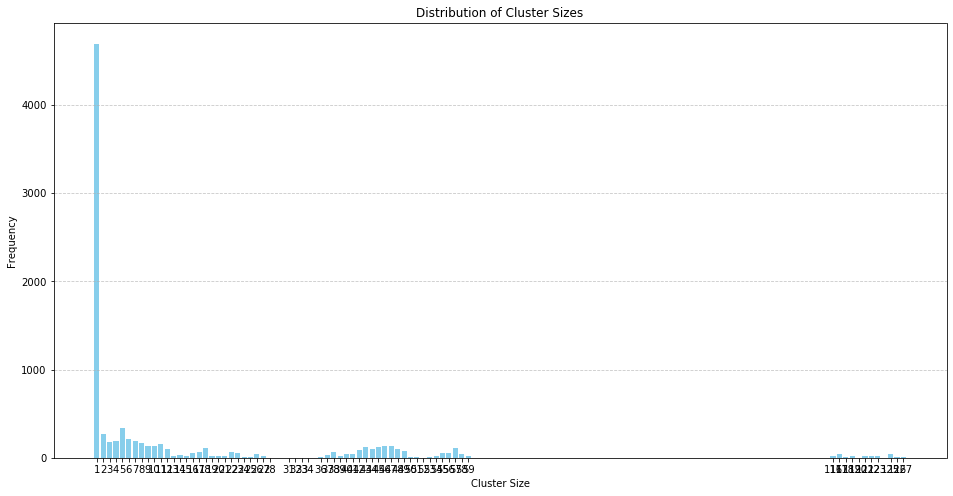

In [15]:
# Extract sizes and their counts from the counter
sizes = list(cluster_size_counter.keys())
counts = list(cluster_size_counter.values())

# Create a bar plot
plt.figure(figsize=(16, 8))
plt.bar(sizes, counts, color='skyblue')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Sizes')
plt.xticks(sizes)  # Ensure each cluster size is a tick on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()